## Name: Phuong Do
# Insulation Effect on Energy Consumption and Its High-Impact Areas
#### In this project, I aim to investigate the impact of insulation adequacy on households' energy consumption and identify the areas most affected by insulation levels. Our primary objective is to assess whether insulation is an effective method for energy savings in the modern age, and if so, to pinpoint which areas would benefit most from insulation. This project will analyze approximately 18,500 Residential Energy Consumption Surveys from representative households conducted in 2020.
#### 1. Filtering invalid responses and cleaning the dataset
#### 2. Displaying data visualizations
#### 3. Discussions and conclusions

##### Datasource: U.S. Energy Information Administration - Residential Energy Consumption Survey (RECS) 2020 Microdata, [https://www.eia.gov/consumption/residential/data/2020/index.php?view=microdata](https://www.eia.gov/consumption/residential/data/2020/index.php?view=microdata)

## I. Data Cleaning and Preprocessing
### a. Importing Necessary Libraries/Packages

In [102]:
import csv 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

### b. Filtering Invalid Responses

In [105]:
filepath = "C:/Users/phuon/OneDrive/AEP/recs2020_public_v7.csv"
columns_to_analyze = ['state_postal', 'IECC_climate_code', 'UATYP10', 'HDD65', 'CDD65', 'TYPEHUQ', 'YEARMADERANGE', 'ADQINSUL',
                      'KWH', 'KWHSPH', 'KWHCOL', 'TOTHSQFT', 'TOTCSQFT', 'TOTSQFT_EN',
                      'NHSLDMEM', 'NUMPORTEL', 'NUMFIREPLC', 'NUMDLHP', 'NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC', 'NUMCFAN', 'NUMFLOORFAN', 'NUMPORTHUM', 'NUMPORTDEHUM', 
                      'SQFTINCB', 'SQFTINCA', 'SQFTINCG',
                      'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'BASEHEAT', 'ATTCHEAT', 'GARGHEAT']

# Load dataset with relevant columns
df_raw = pd.read_csv(filepath, dtype=str, low_memory=False, quoting=csv.QUOTE_ALL, encoding='utf-8', usecols=columns_to_analyze)

# Verify data shape
print('Raw dataset:', df_raw.shape)

# Invalid Basement Conditions
invalid_basement_1 = (df_raw['SQFTINCB'] == '1') & (df_raw['BASECOOL'] == '0') & (df_raw['BASEHEAT'] == '0')
invalid_basement_2 = (df_raw['SQFTINCB'] == '0') & ((df_raw['BASECOOL'] == '1') | (df_raw['BASEHEAT'] == '1'))
invalid_basement_3 = (df_raw['SQFTINCB'] == '-2') & ((df_raw['BASECOOL'] != '-2') | (df_raw['BASEHEAT'] != '-2'))
invalid_basement = invalid_basement_1 | invalid_basement_2 | invalid_basement_3

# Invalid Attic Conditions
invalid_attic_1 = (df_raw['SQFTINCA'] == '1') & (df_raw['ATTCCOOL'] == '0') & (df_raw['ATTCHEAT'] == '0')
invalid_attic_2 = (df_raw['SQFTINCA'] == '0') & ((df_raw['ATTCCOOL'] == '1') | (df_raw['ATTCHEAT'] == '1'))
invalid_attic_3 = (df_raw['SQFTINCA'] == '-2') & ((df_raw['ATTCCOOL'] != '-2') | (df_raw['ATTCHEAT'] != '-2'))
invalid_attic = invalid_attic_1 | invalid_attic_2 | invalid_attic_3

# Invalid Garage Conditions
invalid_garage_1 = (df_raw['SQFTINCG'] == '1') & (df_raw['GARGCOOL'] == '0') & (df_raw['GARGHEAT'] == '0')
invalid_garage_2 = (df_raw['SQFTINCG'] == '0') & ((df_raw['GARGCOOL'] == '1') | (df_raw['GARGHEAT'] == '1'))
invalid_garage_3 = (df_raw['SQFTINCG'] == '-2') & ((df_raw['GARGCOOL'] != '-2') | (df_raw['GARGHEAT'] != '-2'))
invalid_garage = invalid_garage_1 | invalid_garage_2 | invalid_garage_3

# Combine all invalid conditions: A row is invalid if ANY of these conditions are true
overall_invalid_rows = invalid_basement | invalid_attic | invalid_garage

# Filter the DataFrame to keep only the valid rows
df = df_raw[~overall_invalid_rows].copy()

# Verify data shape again
print('Filtered dataset:', df.shape)

Raw dataset: (18496, 34)
Filtered dataset: (13509, 34)


### c. Cleaning and Mapping Dataset

In [108]:
# Handle missed values
df.isnull().sum()

# Drop rows with missing values for critical columns
df.dropna(subset=['KWH', 'KWHSPH', 'KWHCOL', 'TOTHSQFT', 'TOTCSQFT', 'TOTSQFT_EN', 'ADQINSUL', 'IECC_climate_code', 'TYPEHUQ'], inplace=True)

#Replace 'not applicable' with NaN
df.replace(['-2', ''], np.nan, inplace=True)

# Convert data type
for col in columns_to_analyze:
    if col in df.columns:
        # Use float for continuous variables
        if col in ['HDD65', 'CDD65', 'KWH', 'KWHCOL', 'KWHSPH', 'TOTHSQFT', 'TOTCSQFT', 'TOTSQFT_EN']:
            df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')
        # Use integer for count variables
        if col in ['NHSLDMEM', 'NUMPORTHUM', 'NUMPORTDEHUM', 'NUMPORTEL', 'NUMFIREPLC', 'NUMDLHP', 'NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC', 'NUMCFAN', 'NUMFLOORFAN']:
            df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
            

# Map ADQINSUL to insulation level
adqinsul_labels = {'1': 'Well-Insulated', '2': 'Adequately Insulated', '3': 'Poorly Insulated', '4': 'No Insulation'}
df['ADQINSUL'] = df['ADQINSUL'].map(adqinsul_labels)

# Map TYPEHUQ to housing types (simplified)
typehuq_labels = {'1': 'Mobile Home', '2': 'Detached Home', '3': 'Attached Home', '4': 'Small Apt.', '5': 'Big Apt.'}
df['TYPEHUQ'] = df['TYPEHUQ'].map(typehuq_labels)

# Map YEARMADERANGE to specific year ranges
yearmade_labels = {'1': 'Before 1950', '2': '1950s', '3': '1960s', '4': '1970s',
                   '5': '1980s', '6': '1990s', '7': '2000s', '8': '2010-2020', '9': '2010-2020'}
df['YEARMADERANGE'] = df['YEARMADERANGE'].map(yearmade_labels)

# Map UATYP10 to area type
uatyp10_labels = {'C': 'Urban Cluster', 'R': 'Rural Area', 'U': 'Urban Area'}
df['UATYP10'] = df['UATYP10'].map(uatyp10_labels)

#Check data type
# for column in df.columns:
#     print(f"{column}: {df[column].dtype}")

#Display 10 random columns after cleaning the dataset
df.sample(n=10, random_state=42)

,state_postal,IECC_climate_code,UATYP10,HDD65,CDD65,TYPEHUQ,YEARMADERANGE,ADQINSUL,NUMPORTEL,NUMFIREPLC,...,NHSLDMEM,SQFTINCB,SQFTINCA,SQFTINCG,TOTSQFT_EN,TOTHSQFT,TOTCSQFT,KWH,KWHSPH,KWHCOL
9525,CA,3B,Urban Area,2469.0,1973.0,Detached Home,1970s,Adequately Insulated,NaN,1.0,...,2,NaN,0,NaN,1600.0,1600.0,1600.0,9543.73,0.00,2266.50
6084,TX,3A,Urban Area,1868.0,2779.0,Detached Home,1970s,No Insulation,NaN,NaN,...,2,NaN,NaN,NaN,960.0,960.0,380.0,12597.07,2891.93,3374.87
17300,NY,5A,Urban Area,5948.0,965.0,Big Apt.,1950s,No Insulation,2.0,NaN,...,3,NaN,NaN,NaN,600.0,600.0,0.0,2205.85,89.69,0.00
4349,AK,7AK,Urban Area,10611.0,2.0,Small Apt.,1970s,Adequately Insulated,NaN,NaN,...,1,NaN,NaN,NaN,770.0,770.0,0.0,1768.66,0.00,0.00
4579,SC,3A,Urban Area,1943.0,2301.0,Mobile Home,1980s,Adequately Insulated,NaN,NaN,...,3,NaN,NaN,NaN,1090.0,1090.0,1090.0,20525.40,6872.95,4364.82
1263,CA,3C,Urban Area,2007.0,909.0,Detached Home,1950s,Adequately Insulated,NaN,1.0,...,2,NaN,NaN,1,2000.0,2000.0,0.0,5756.89,0.00,0.00
794,VA,4A,Rural Area,4267.0,983.0,Detached Home,1970s,Adequately Insulated,3.0,NaN,...,2,NaN,NaN,NaN,800.0,800.0,160.0,21772.44,11145.26,566.66
13922,WI,6A,Rural Area,8090.0,515.0,Detached Home,1970s,Adequately Insulated,NaN,NaN,...,1,1,NaN,0,1780.0,1780.0,1780.0,7104.63,0.00,861.89
2003,CO,5B,Urban Area,5482.0,1060.0,Small Apt.,2010-2020,Adequately Insulated,NaN,NaN,...,1,NaN,NaN,NaN,600.0,600.0,600.0,4455.26,1146.16,265.70
12424,VA,4A,Urban Area,4150.0,1294.0,Detached Home,1990s,Well-Insulated,NaN,NaN,...,2,1,0,0,3500.0,3500.0,3500.0,13171.66,0.00,4437.75


## II. Data Analysis and Visualizations
### a. Total Energy Consumption (kWh/SqFt) by Insulation Adequacy

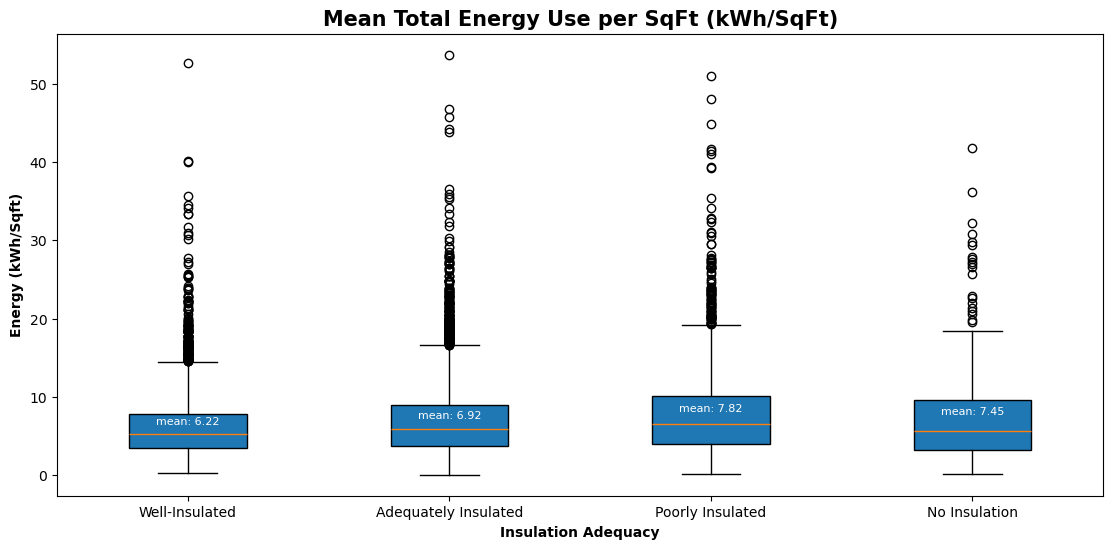

In [111]:
# Define order
insulation_order = ['Well-Insulated', 'Adequately Insulated', 'Poorly Insulated', 'No Insulation']

# Handle potential division by zero by replacing 0 with NaN in TOTSQFT_EN
df['TOTSQFT_EN'] = df['TOTSQFT_EN'].replace(0, pd.NA)

# Calculate total energy consumption in KWH per square foot
df['KWH_per_SQFT'] = df['KWH'] / df['TOTSQFT_EN']

# Prepare data for boxplot: group KWH_per_SQFT by ADQINSUL categories
total_energy_consumption = []
for category in insulation_order:
    kwh_per_sqft_values = df[df['ADQINSUL'] == category]['KWH_per_SQFT'].dropna()
    total_energy_consumption.append(kwh_per_sqft_values.tolist() if not kwh_per_sqft_values.empty else [0])

# Calculate means for each category
means = [pd.Series(data).mean() if data else 0 for data in total_energy_consumption]

# Create the boxplot
plt.figure(figsize=(13.5, 6))
box = plt.boxplot(total_energy_consumption, labels=insulation_order, patch_artist=True)

# Add mean annotations
for i, mean in enumerate(means):
    plt.text(i + 1, mean, f'mean: {mean:.2f}', ha='center', va='bottom', color='white', fontsize=8)
plt.title('Mean Total Energy Use per SqFt (kWh/SqFt)', weight="bold", fontsize=15)
plt.xlabel('Insulation Adequacy', weight="bold")
plt.ylabel('Energy (kWh/Sqft)', weight="bold")
plt.xticks()
plt.show()

### b. Heating and Cooling Energy Consumption (kWh/SqFt) by Insulation Adequcy

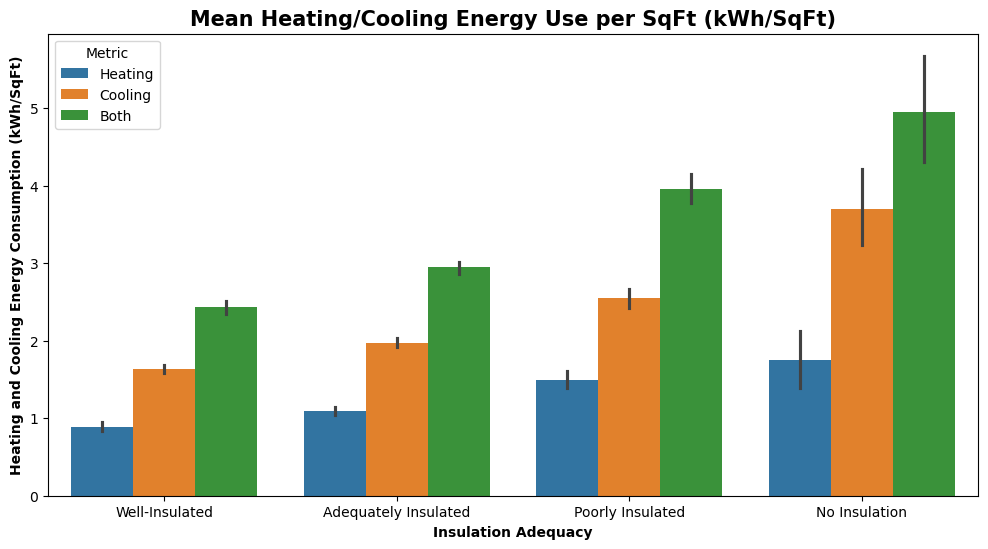

In [114]:
# Handle potential division by zero by replacing 0 with NaN in TOTHSQFT and TOTCSQFT
df['TOTHSQFT'] = df['TOTHSQFT'].replace(0, pd.NA)
df['TOTCSQFT'] = df['TOTCSQFT'].replace(0, pd.NA)

# Calculate heating/cooling energy consumption in KWH per square foot
df['KWHSPH_per_TOTHSQFT'] = df['KWHSPH'] / df['TOTHSQFT']
df['KWHCOL_per_TOTCSQFT'] = df['KWHCOL'] / df['TOTCSQFT']
df['KWHSPH_KWHCOL'] = df['KWHSPH_per_TOTHSQFT'] + df['KWHCOL_per_TOTCSQFT']

# Melt the DataFrame to combine KWHSPH_per_TOTHSQFT and KWHCOL_per_TOTCSQFT
df_melted = df.melt(id_vars=['ADQINSUL'], 
                    value_vars=['KWHSPH_per_TOTHSQFT', 'KWHCOL_per_TOTCSQFT', 'KWHSPH_KWHCOL'], 
                    var_name='Metric', 
                    value_name='KWH_per_SqFt')

# Map the metric names for better readability in the plot
df_melted['Metric'] = df_melted['Metric'].map({
    'KWHSPH_per_TOTHSQFT': 'Heating',
    'KWHCOL_per_TOTCSQFT': 'Cooling',
    'KWHSPH_KWHCOL': 'Both'
})

# Visualize Combined Metrics in One Graph
plt.figure(figsize=(12, 6))
sns.barplot(x='ADQINSUL', y='KWH_per_SqFt', hue='Metric', order=insulation_order, data=df_melted)
plt.title('Mean Heating/Cooling Energy Use per SqFt (kWh/SqFt)', weight='bold', fontsize=15)
plt.xlabel('Insulation Adequacy', weight='bold')
plt.ylabel('Heating and Cooling Energy Consumption (kWh/SqFt)', weight='bold')
plt.xticks()
plt.show()

### c. Correlations between Heating and Cooling Energy Consumption and Selected Factors by Insulation Adequacy

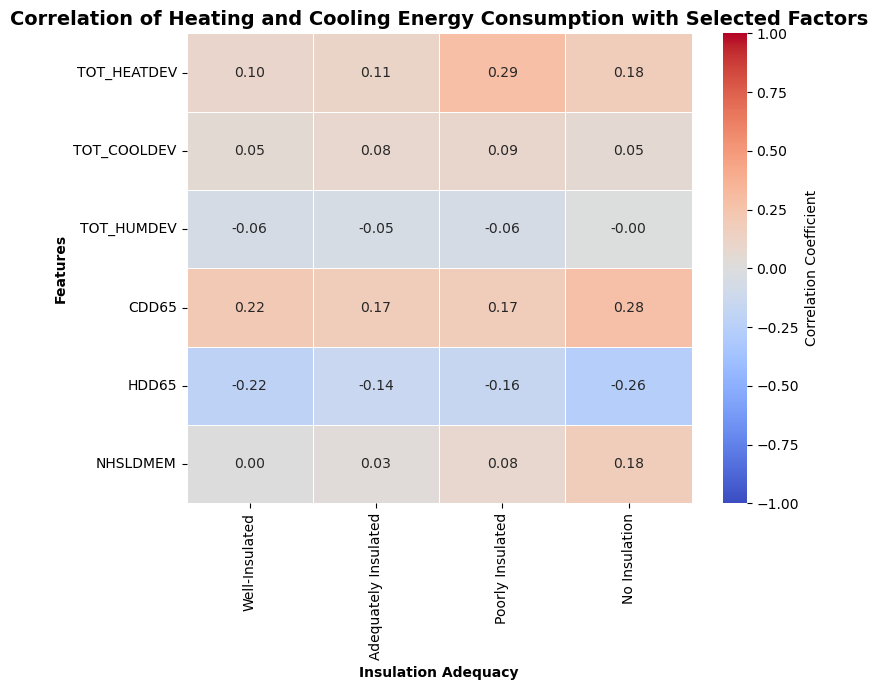

In [117]:
# Define the heating and cooling device variables
heating_vars = ['NUMPORTEL', 'NUMFIREPLC', 'NUMDLHP']
cooling_vars = ['NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC', 'NUMCFAN', 'NUMFLOORFAN']
humidity_vars = ['NUMPORTHUM', 'NUMPORTDEHUM']

# Create new columns for total heating and cooling devices
df['TOT_HEATDEV'] = df[heating_vars].sum(axis=1)
df['TOT_COOLDEV'] = df[cooling_vars].sum(axis=1)
df['TOT_HUMDEV'] = df[humidity_vars].sum(axis=1)

# Define the variables to compare with KWH_per_SQFT
features = ['TOT_HEATDEV', 'TOT_COOLDEV', 'TOT_HUMDEV','CDD65', 'HDD65', 'NHSLDMEM']

# Calculate correlations for each ADQINSUL category
correlations = {}
for category in insulation_order:
    subset = df[df['ADQINSUL'] == category]
    correlations[category] = subset[features].corrwith(subset['KWHSPH_KWHCOL'])

# Convert correlations to a DataFrame for heatmap
corr_df = pd.DataFrame(correlations, index=features)

# Create the heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation of Heating and Cooling Energy Consumption with Selected Factors', 
          weight='bold', fontsize=14)
plt.xlabel('Insulation Adequacy', weight='bold')
plt.ylabel('Features', weight='bold')
plt.tight_layout()
plt.show()

### d. Heating and Cooling Energy Consumption by Insulation Adequacy Across Different Climate Zones, Contrunction Ages, Housing Types, and Areas

=== Climate Zones Ranking ===
    Rank Category Percentage Change
0      1       6B         83.166658
1      2       4C         74.866672
2      3       5B         64.229098
3      4       2A         64.010241
4      5       5A         58.389431
5      6       2B         46.568766
6      7       3A         41.553972
7      8       4A         35.654947
8      9       1A         35.053833
9     10       4B         30.794783
10    11       3B         23.554311
11    12       6A         -2.768182
12    13       3C        -10.692013
13    14       7A        -83.833886
14    15      7AK               NaN
15    16       7B               NaN
16    17      8AK               NaN

=== Housing Types Ranking ===
   Rank       Category Percentage Change
0     1  Attached Home         69.930303
1     2  Detached Home         57.256556
2     3       Big Apt.         46.314515
3     4    Mobile Home         37.855092
4     5     Small Apt.         27.980452

=== Construction Ages Ranking ===
   Rank   

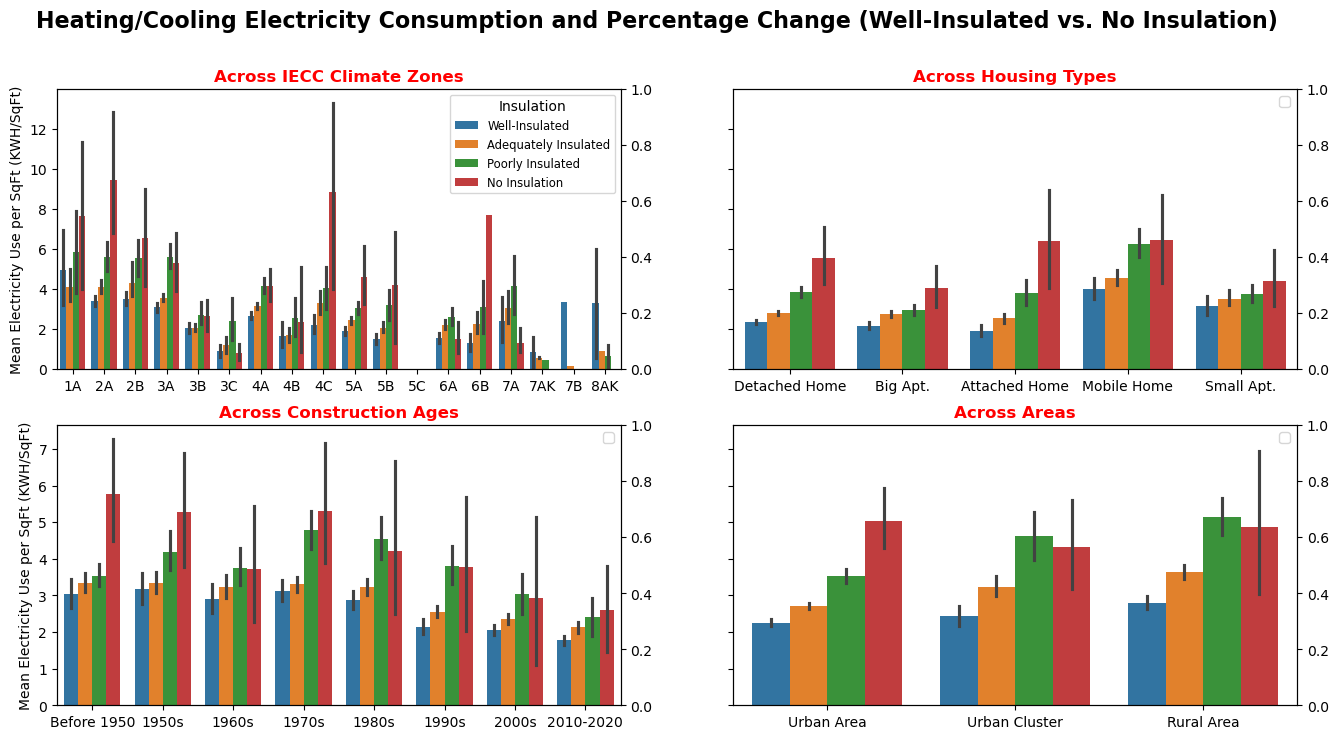

In [120]:
# Define orders 
climate_order = ["1A", "2A", "2B", "3A", "3B", "3C", "4A", "4B", "4C", "5A", "5B", "5C", "6A", "6B", "7A", "7AK", "7B", "8AK"]
yearmade_order = ['Before 1950', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010-2020']

# Function to calculate percentage change
def calc_percentage_change(df, group_by_col):
    means = df.groupby([group_by_col, 'ADQINSUL'])['KWHSPH_KWHCOL'].mean().unstack()
    change = ((means['No Insulation'] - means['Well-Insulated']) / means['No Insulation']) * 100
    return change.reset_index().rename(columns={0: 'Percentage Change'})

# Creat a ranking table for each category
def create_ranked_table(df, category_name, value_column):
    ranked_df = df.sort_values(by='Percentage Change', ascending=False).reset_index(drop=True)
    ranked_df['Rank'] = ranked_df.index + 1
    ranked_df = ranked_df[['Rank', value_column, 'Percentage Change']]
    ranked_df = ranked_df.rename(columns={value_column: 'Category'})
    return ranked_df

# Calculate percentage change for each category
change_climate = calc_percentage_change(df, 'IECC_climate_code')
change_housing = calc_percentage_change(df, 'TYPEHUQ')
change_year = calc_percentage_change(df, 'YEARMADERANGE')
change_area = calc_percentage_change(df, 'UATYP10')

# Create 2x2 grid of subplots for the dual-axis plots
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharey='row')
fig.suptitle('Heating/Cooling Electricity Consumption and Percentage Change (Well-Insulated vs. No Insulation)', fontsize=16, fontweight='bold')

# 1. IECC climate Plot
sns.barplot(x='IECC_climate_code', y='KWHSPH_KWHCOL', hue='ADQINSUL', hue_order=insulation_order, order=climate_order, data=df, ax=axes[0, 0])
axes[0, 0].set_title('Across IECC Climate Zones', fontweight='bold', color='red')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Mean Electricity Use per SqFt (KWH/SqFt)')
axes[0, 0].legend(title='Insulation', fontsize='small')
ax2 = axes[0, 0].twinx()

# 2. TYPEHUQ Plot
housing_types = df['TYPEHUQ'].unique()
sns.barplot(x='TYPEHUQ', y='KWHSPH_KWHCOL', hue='ADQINSUL', hue_order=insulation_order, data=df, ax=axes[0, 1])
axes[0, 1].set_title('Across Housing Types', fontweight='bold', color='red')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].legend('')
ax2 = axes[0, 1].twinx()

# 3. YEARMADERANGE Plot
sns.barplot(x='YEARMADERANGE', y='KWHSPH_KWHCOL', hue='ADQINSUL', hue_order=insulation_order, order=yearmade_order, 
            data=df, ax=axes[1, 0])
axes[1, 0].set_title('Across Construction Ages', fontweight='bold', color='red')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Mean Electricity Use per SqFt (KWH/SqFt)')
axes[1, 0].legend('')
ax2 = axes[1, 0].twinx()

# 4. UATYP10 Plot
area_types = df['UATYP10'].unique()
sns.barplot(x='UATYP10', y='KWHSPH_KWHCOL', hue='ADQINSUL', hue_order=insulation_order, data=df, ax=axes[1, 1])
axes[1, 1].set_title('Across Areas', fontweight='bold', color='red')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].legend('')
ax2 = axes[1, 1].twinx()

# Create ranked tables for each category
climate_ranked = create_ranked_table(change_climate, 'Climate Zones', 'IECC_climate_code')
housing_ranked = create_ranked_table(change_housing, 'Housing Types', 'TYPEHUQ')
year_ranked = create_ranked_table(change_year, 'Construction Ages', 'YEARMADERANGE')
area_ranked = create_ranked_table(change_area, 'Areas', 'UATYP10')

# Display each table with a header
print("=== Climate Zones Ranking ===")
print(climate_ranked)
print("\n=== Housing Types Ranking ===")
print(housing_ranked)
print("\n=== Construction Ages Ranking ===")
print(year_ranked)
print("\n=== Areas Ranking ===")
print(area_ranked)

## III. Discussions 
### A. Eliminating Invalid Responses to Avoid Deflection/Inflaction in Energy Consumption
In this project, energy consumption is calculated by dividing the total electricity consumption by the total reported areas (kWh/sq.ft), instead of using the values on the bills directly - which aims to capture the energy consumption in term of density. Moreover, as only the energy used for heating and cooling is analyzed innstead of the total energy consumption - for our assumption that insulation impacts only the heat transfer process and not neccesarily other energy consumption habits, some responses are eliminated for not providing enough data. Below some examples for your reference:
1. Respondents have their garage/attic/basement heated or cooled but don't include its area in the reported response, which inflates the actual enegry consumption.
2. Respondents don't have their garage/attic/basement heated or cooled but include its area in the reported response, which deflates the actual enegry consumption.
3. Respondents who don't have a consistency in their report of whether they have garage/attic/basement.

Filtering the responses by these conditions, we make sure the energy consumption is neither deflated nor inflated, reflect a more accurate energy consumption.
### B. Accessing the Difference betwwen Total Energy Consumption and Heating/Cooling Energy Consumption with Insulation Adequacy
The total energy consumption (average) increases as insulation adequacy decreases from well, adequate, to poor condition, 6.22, 6.92, and 7.82 kkWh/sq.ft, respectively. However, the energy density slightly decreases to 7.45 kkWh/sq.ft for households with no insulation. 
But for both heating and cooling energy consumption, the trend is more intuitive, increasing gradually as insulation level worsens and - as the result, housing units without insulation consume the most energy for heating and cooling activities.
These observation suggest that 'no-insulation' households consume much less energy in other areas outside heating and cooling than 'poorly insulated' ones, given the fact that the latter has higher total energy consumption but lower in heating and cooling.
### C. Discussing the factors that have correlations with heating/cooling energy consumption
The total number of heating devices has higher correlations with heating/cooling energy consumption as insulation level gets worse (almost tripling, from 0.11 for well-insulated house to 0.29 for poorly-insulated one), but the correlation slightly decreases to 0.18 for no insulation. The same trend is also observed for cooling devices, meaning that there is other factors impacting heating/cooling energy consumption rather the numbers of devices themselve for no insulation house. However, one difference is that cooling devices share much lower correlations with energy consumption - with no values exceeding 0.1. This could be that other factors like efficiency or usage patterns might have more impact on cooling energy the the number of devices.
The number of (de)humidifiers show neither clear nor strong correlations to the amount of energy consumption for all insulation levels, suggesting heating/cooling energy, regardless of insulation adequacy, is not correlated to the number of (de)humidifiers.
Lastly, for the number of household members, its correlation with heating/cooling energy consumption tends to get higher with decreasing insulation levels - with almost 0 for well-insulated to 0.18 for no insulation. This indicates that as the insulation level decreases - energy consumption tends to more vulnerable with increasing number of members. 
### D. Some areas benefit more from insulation than the others
#### 1. IECC Climate Zone
Insulation is most effective in colder and mixed climates (6B, 4C, 5B, 5A), with energy savings ranging from 58% to 83%. These zones likely have high heating demands, and insulation reduces heat loss, leading to substantial energy savings. There is no data for no-insulation households in 7AK, 7B, and 8AK climate zones, suggesting that the cold weather in these areas leave no household uninsulated. Warmer areas and mixed climates (2A, 2B, 3A, 4A, 1A) also save energy by having proper insulation, just with slightly lower impact compared to colder ones. The observation indicates that while heating energy consumption is higher than cooling one, insulation has a slightly higher impact in colder area. These zones, 6A (-2.77%), 3C (-10.69%), and 7A (-83.83%), show negative change, indicating that well-insulated homes use more energy than those with no insulation in these zones, which is unexpected and suggests potential issues or unique conditions.
#### 2. Housing Types
Attached Homes achieving the highest energy savings at 69.93%, followed by Detached Homes at 57.26%, likely due to reduced heat loss through shared or exposed walls in these structures. Big Apartments (46.31%) and Mobile Homes (37.86%) show moderate savings, while Small Apartments have the lowest at 27.98%, possibly due to lower surface area-to-volume ratios or different occupancy patterns. The high performance of attached and detached homes suggests that insulation is particularly effective in single-family structures, where exposed surfaces are significant, making these housing types prime candidates for insulation upgrades to maximize energy efficiency.
#### 3. Construction Ages
Homes built Before 1950 show the highest energy savings from insulation at 47.69%, likely due to poor original construction standards that benefit significantly from modern insulation. Newer homes from the 1990s (43.17%) and 1970s (41.04%) also exhibit strong savings, possibly reflecting construction practices that still allow insulation to make a substantial impact. In contrast, 2010–2020 (32.23%) and 2000s (30.23%) homes show lower savings, likely due to already improved baseline insulation standards, while 1960s homes rank lowest at 21.92%. This suggests that older homes, particularly pre-1950, offer the greatest potential for energy efficiency gains through insulation retrofits.
#### 4. Areas
Insulation is most effective in Urban Areas, with 55.03% energy savings, followed closely by Urban Clusters (43.49%) and Rural Areas (42.53%), indicating that urban environments benefit slightly more from insulation, possibly due to higher building density or exposure to urban heat island effects that amplify heating and cooling needs. This underscores the value of targeting insulation upgrades in urban settings to achieve significant energy reductions.

## IV. Conclusions
Insulation significantly reduces heating and cooling energy consumption, particularly in colder/mixed climate zones, older single-family homes, and urban areas. Especially, as the number of household member increases, energy can be saved more in home of better insulation. Anomalies in zones like 6A, 3C, and 7A indicate potential data issues or unique factors that warrant further study. Non-heating/cooling energy use in no-insulation homes suggests alternative efficiency measures may also be critical.
